# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 3B. Labelled Dataset - "Bag of Words" Modelling  - Relevant and Irrelevant

## Introduction

In this notebook, I focus on modelling using the labelled up-sampled dataset. 

As a reminder, my labelled dataset has 5 classes of "Intent" - 'yes', 'maybe', 'uncertain', 'informative' and 'no'. I experimented with different strategies of binary encoding my target variable "Intent". The previous notebook, titled "Notebook 03-A", delved into the modeling results for the encoding strategy where "yes" and "no" were combined into one category, and other categories were excluded. This present  "Notebook 03-B" will explore the results of the alternate encoding strategy, differentiating between "relevant" and "irrelevant" classes.

This notebook discusses teh results of models where the encoding has been done by **grouping "yes" and "no" responses into a single category, labeled "relevant"**. These messages, despite having opposite sentiments, express a stance on the attractiveness of shares and are distinct from messages discussing unrelated events or lacking an opinion. The other group, "irrelevant", includes informative and unrelated messages.

In this notebook I perform basic modelling for the labelled dataset that was upsampled with new 450 messages generated using OpenAI APIs. 

This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Gridsearch for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. SVM Classifier
* 3.7. Random Forest Model
* 3.8. Conclusions on the relevant/Irrelevant encoding strategy.


* 3.9. Testing application of both models of the full labelled dataset

## 3.0 Data loading and data quality checks

In [1]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# Pipeline Utilities
from sklearn.pipeline import Pipeline, make_pipeline

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

# Serialization/Deserialization Libraries
from joblib import dump
import dill as pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the pre-processed labelled dataset (result of work done in Notebook 01). 
# This version of the dataset has emojis preserved.
DATAFILE = '../data/02_labelled_dataset_cleaned.csv'
df1 = pd.read_csv(DATAFILE)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   word_count  4996 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 273.3+ KB


In [4]:
# Dropping non-essential rows that carry no text
df1=df1.drop(columns=['parent_id', 'User', "Support",'word_count']) #"emoji_text"])

In [5]:
# Rename the 'link_id' column to 'id'
df1 = df1.rename(columns={'link_id': 'id'})

In [6]:
# Counting duplicated rows
df1.duplicated().sum()

3

In [7]:
# Removing duplicate rows
df1 = df1.drop_duplicates()

In [8]:
# Loading the negative messages upsampled using openAi APis:
DATAFILE2 = '../data/reddit_gpt4_negative_only_cleaned.csv'
df2 = pd.read_csv(DATAFILE2)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               450 non-null    object
 1   title            450 non-null    object
 2   selftext         314 non-null    object
 3   Text             450 non-null    object
 4   token_count      450 non-null    int64 
 5   Sentiment_Tag    450 non-null    object
 6   Sentiment_Tag_2  450 non-null    object
dtypes: int64(1), object(6)
memory usage: 24.7+ KB


In [10]:
# Dropping non-essential or redundant rows:
df2=df2.drop(columns=['title', 'selftext', 'token_count', 'Sentiment_Tag'])

In [11]:
# Rename the 'Sentiment_Tag_2' column to 'Intent'
df2 = df2.rename(columns={'Sentiment_Tag_2': 'Intent'})

In [12]:
df2.describe()

,id,Text,Intent
count,450,450,450
unique,441,441,1
top,mpbyzf,"4/12/2021 GME Borrowables Alert 7.30am, Hey gu...",Negative
freq,2,2,450


In [13]:
# checking for duplicates after the steps above
df2.duplicated().sum()

9

In [14]:
# Dropping the duplicates 
df2.drop_duplicates()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative
...,...,...,...
445,msla5l,"Gme going to zero, invest in Broccoli futures ...",Negative
446,ril23c,Hilarious how much msm is pumping popcorn toda...,Negative
447,ncf668,"Maybe they shorted GME, nan",Negative
448,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,Negative


In [15]:
# Checking the result of the steps above
df2.head(5)

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative


In [16]:
# Replace 'Negative' with 'n' in the 'Intent' column
df2['Intent'] = df2['Intent'].replace("Negative", "n")

In [17]:
# Replace 'NaN' and 'nan' with an empty string in the 'Text' column of df2
df2['Text'] = df2['Text'].str.replace('NaN|nan', '', regex=True)

In [18]:
# Concatenate df and df2 vertically
df = pd.concat([df1, df2], ignore_index=True)
df

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y
...,...,...,...
5438,msla5l,"Gme going to zero, invest in Broccoli futures ...",n
5439,ril23c,Hilarious how much msm is pumping popcorn toda...,n
5440,ncf668,"Maybe they shorted GME,",n
5441,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,n


In [19]:
df['Intent'].value_counts()

Intent
u    3245
y     983
n     533
m     370
i     312
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443 entries, 0 to 5442
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5443 non-null   object
 1   Text    5443 non-null   object
 2   Intent  5443 non-null   object
dtypes: object(3)
memory usage: 127.7+ KB


* The datasets have been successfully concatenated into one single dataframe. Both have been pre-cleaned using similar steps. 
* We have 5443 rows now to work with.
* Saving the result into a CSV file.  

In [21]:
df.to_csv('../data/03_labelled_GPT_upsampled_.csv', index=False)

Looking at the distribution of our classes in the target colulmn "Intent":

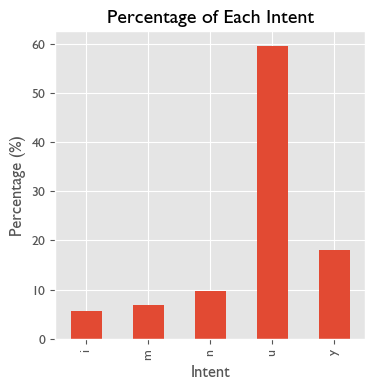

In [22]:
# Calculating the percentage of each intent category relative to the total
intent_percentages = df['Intent'].value_counts(normalize=True).sort_index() * 100

# Plotting the percentages
ax = intent_percentages.plot(kind='bar', title='Percentage of Each Intent', figsize=(4, 4))
ax.set_xlabel('Intent')
ax.set_ylabel('Percentage (%)')

# Display the plot
plt.show()

* Majority of posts (60%) received clasification 'u', which means 'uncertain'. 
* 18% of posts were rated as "positive" signalling an intent to buy GME shares.
* Negative messages ('n') are still a minority, only  10% of the messages were rated as "negative" which still creates an  imbalance in our dataset.  I still have a deficit of examples of negative posts, but this is much better than before.

## 3.1. Assigning target variable

In [23]:
df.head(5)

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y


In [24]:
# Droppinhg the rows where 'Intent' is 'm', 'i', or 'u'
# df = df[~df['Intent'].isin(['m', 'i', 'u'])]

In [25]:
# Assigning target variable to (Y+N) = 1, and (M, U, I)= 0.

df = df.copy() 

# Two classes together as 1s
df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'n'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one class as 1s
# df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,0
1,t3_ki3745,"Oh GME, you tease!",0
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",0
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,0
4,t3_l9xqem,Just got into $GME @ 220.,1


In [26]:
df['Intent'].value_counts()

Intent
0    3927
1    1516
Name: count, dtype: int64

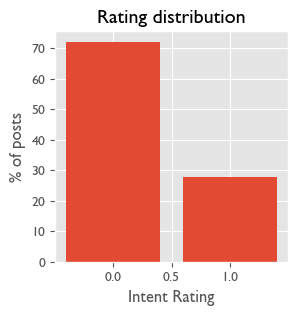

Class imbalance: [0.72 0.28]


In [27]:
# Checking the distribution of binary classes:

values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Tokenization options

In the dataset I've been working with, the primary focus is on the intention to buy shares in GameStop, a company that was a hot topic in the WallStreetBets (WSB) community during Q1 2021. Given that the discussions frequently centered around GameStop, identified by its name or its stock exchange ticker "GME", it was crucial for my analysis to filter out these specific references. This is because I wanted to ensure that my model could effectively identify buy or sell recommendations without being biased towards discussions solely focused on  GameStop. 

Additionally, other companies like Blackberry ("BB") and AMC were also popular in these discussions. To address this, I crafted a custom list of stop words designed to exclude these specific company names and tickers from my textual analysis. By incorporating this custom stop words list into my bag-of-words analysis, I wanted to create a more robust model that could generalize across various company discussions, rather than being narrowly focused on a few frequently mentioned ones.

In [28]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'amc', 'nok', 'bb', 'game', 'pltr', 'spy']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

the code below is my custom cleaning function designed for the BOW (bag of words) approach. 

In [29]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

### Train test split

In [34]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4354,)

In [35]:
print(y_test.shape)

(1089,)


## 3.2. Vectorisation 

In [36]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using custom stop words 
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

(4354, 1000)


In [37]:
# count the  most common words
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
buy,1109
stock,869
share,830
go,734
short,684
like,673
hold,672
sell,624
get,598
fuck,557


the list of words is pretty much as expected, with a heavy focus on investment related words - stock, share, buy, sell, holding, money, market, etc.  No surprises here. 

In [38]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,abl,absolut,access,accord,account,act,action,activ,actual,ad,...,wtf,x,ya,ye,yeah,year,yesterday,yet,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


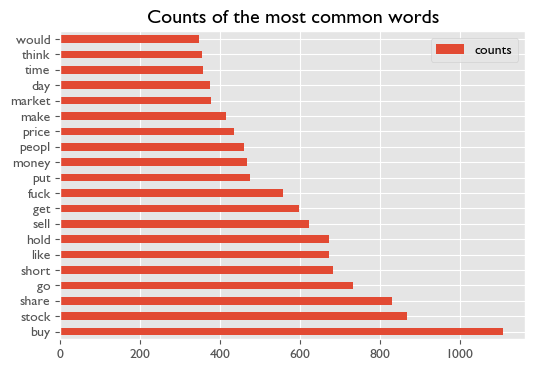

In [39]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

In [40]:
print(word_counts)

            counts
buy           1109
stock          869
share          830
go             734
short          684
...            ...
cri             14
sell order      14
shitti          14
count           14
debt            14

[1000 rows x 1 columns]


### SMOTE sampling due to imbalance

* My dataset is imbalanced with 35% of data being in the negative class. 
* I decided to experiment with resampling the data it using SMOTE technique (synthetic up-sampling). 
* SMOTE helps to mitigate the bias towards the majority class in an imbalanced dataset by generating synthetic samples for the minority class. 
* I expected better results as this should have increased my model's ability to learn from an equally represented dataset, improving its predictive accuracy across all classes. 
* However, the SMOTE upsampling generally did not help muhc, as can be shown later. 

In [41]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [42]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    3141
1    1213
Name: count, dtype: int64


Resampled class distribution


Intent
0    3141
1    3141
Name: count, dtype: int64

In [43]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. Simple Logistic Regression

In [44]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1089, 1000)

In [45]:
logistic_model=LogisticRegression(solver='lbfgs', max_iter=1000) # Also tried  liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.87
Test set accuracy 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       786
           1       0.61      0.47      0.53       303

    accuracy                           0.77      1089
   macro avg       0.71      0.68      0.69      1089
weighted avg       0.76      0.77      0.76      1089

Confusion Matrix:
[[696  90]
 [161 142]]


The baseline logistic regression model shows strong performance on the training set, achieving an accuracy of 87%. However, the accuracy on the test set is 77%, which, while still good, suggests a decrease in performance when applied to unseen data. This indicates some overfitting, which is not unexpected given the dataset's size.

The model shows a somewhat balanced performance across both classes on precision and recall. For the negative class (0s), it achieves a precision of 81% and a recall of 89%, indicating a good ability in identifying true negatives. This is natural given that this is a larger portion of the dataset. In the case of the positive class (1s = yes), the precision is 61%, with a recall of 47%. This suggests that the model is moderately effective in identifying true positives.

The overall accuracy of 77% is okay, but it is not vastly higher than the majority class percentage. The f1-score, which is a harmonic mean of precision and recall, stands at 0.85 for the negative class and 0.53 for the positive class.

Looking at the confusion matrix, we can see that the model is more inclined towards correctly predicting negative intentions (696 correct predictions out of 786 instances) compared to positive intentions (142 correct predictions out of 303 instances). This shows a significant number of "misses" on the positive side.

Overall, while the model shows a good baseline performance, especially in predicting the negative class, it could benefit from further tuning to enhance its accuracy and balance between the classes.

Below I explore more complex models and techniques that lead to improved results.

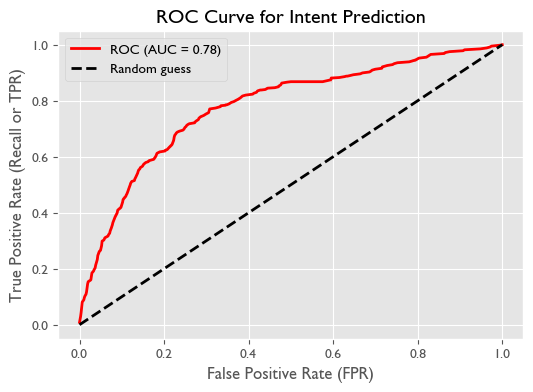

In [46]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] 

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

The ROC AUC shows decent performance, even befor ethe hyperparameters optimisation. 

Train set accuracy after SMOTE 0.82
Test set accuracy after SMOTE 0.65
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       786
           1       0.42      0.65      0.51       303

    accuracy                           0.65      1089
   macro avg       0.62      0.65      0.62      1089
weighted avg       0.71      0.65      0.66      1089

Confusion Matrix after SMOTE:
[[507 279]
 [105 198]]


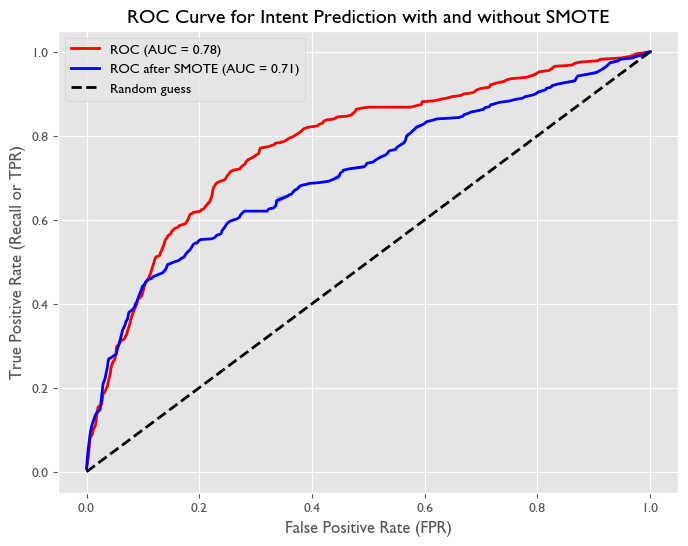

In [47]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Combined Plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})') # without SMOTE
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.title('ROC Curve for Intent Prediction with and without SMOTE')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.legend(loc='best')
plt.show()

The SMOTE technique was applied to reduce imbalance in the dataset between positive and negative classes.  Unfortunately, the SMOTE adjusted data did not result in a better result. Overall, the confidence of the model deteriorated compared to the baseline simple logistric regresison: macro avearges for all indicators (precision, recall, F1) have declined, and the overall test accuracy has declined, too.

### Simple Logistic Regression - Coefficients

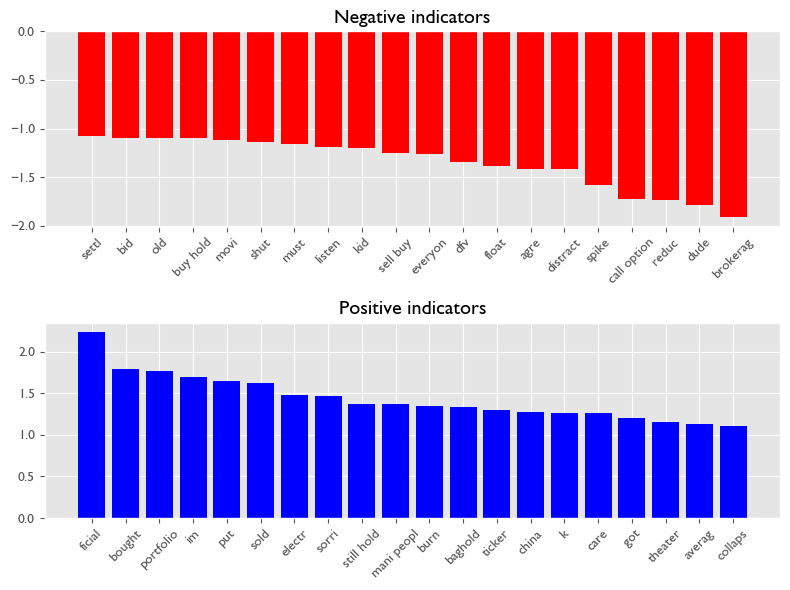

In [130]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

**Observation:**
 
* The messages are being classified into "relevant" and "irrelevant", and it is interesting to see what words are predictive of both classes.
*  The "relevant", i.e. messages that show some investment intention most frequently include words such as "ficial" (I think this is a common misspelling of word financial"), "bought", 'sold", "want to buy", "holding", "investing", "invested" "portfolio" and "beat", "earnings".  These are all investment related words, so this is a good starting point. The relevant messages also include words such as "crash", "dropping", "losing", which indicate the expectations of a loss.  The words such as "many people", "care", "got" don’t add much, they can be in many other messages.  This reflects a small size of my dataset. 
* The irrelevant messages include common words unrelated to investment themes, such as "dude", "person", "everyone", "small", "kid", etc.  However, since we analyse content of investment related discussions there are clearly investment related words appearing in these unrelated messages as well: "short interest", "silver", dividend", float", "call option", "brokerage". It also could be the result of very strict labelling criteria used by the researchers on their labelled dataset, it is hard to tell. 

Conclusion:  the extracted coefficients are very useful as they allow us to analyse what elements of the message are predictive of its classification. 



## 3.4. Logreg Hyperparameters Optimisation

* I use GridSearch with 5 fold cross validation on the training set to search over a specified parameter grid. 
* The GridSearch includes pre-processing steps: vectorisation and logistical regression with various C-factors for regularisation. 
* I experimented with dimensionality reduction using Truncated SVD, but best results were achieved without using it, so I commented it out.
* I also used scaling but it did not change the results significantly but extended the runtime, so I also commented it out.  
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.
* I used several different tokenizers in my gridsearch, all of them were coupled with the custom stop words list.  The best results are achieved with my own custom tokeniser. For some reason, my carefully designed tokenisation options did not perform as well, so I use my tokeniser throughout this notebook.


In [49]:
# Pipeline composition, includes preprocessing and the classifier
pipeline_log = Pipeline([
    ('tfidf_log', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    ('logr_log', LogisticRegression(max_iter=10000))  # Classifier
    #('scaler', StandardScaler(with_mean=False)),  
    #('svd', TruncatedSVD(), None),  # Dimensionality reduction
])

# Define the hyperparameters to search
param_grid_log = {
    'tfidf_log__max_df': [0.6, 0.7, 0.75],
    'tfidf_log__tokenizer': [my_tokenizer],
    'tfidf_log__ngram_range': [(1, 2), (1, 3)],
    'logr_log__C': [10, 100],
    'logr_log__solver': ['lbfgs']
    #'svd__n_components': [400, 500, 1000], # reduce the feature space to the top XXX components
}

In [50]:
# Set up and run GridSearchCV
grid_search_log = GridSearchCV(pipeline_log, param_grid_log, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search_log.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_log',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('logr_log',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logr_log__C': [10, 100],
                         'logr_log__solver': ['lbfgs'],
                         'tfidf_log__max_df': [0.6, 0.7, 0.75],
                         'tfidf_log__ngram_range': [(1, 2), (1, 3)],
                         'tfidf_log__tokenizer': [<function my_tokenizer at 0x2828c61f0>]},
             scoring='f1_weighted', verbose=1)

Best hyperparameters for Logistic Regression: {'logr_log__C': 10, 'logr_log__solver': 'lbfgs', 'tfidf_log__max_df': 0.6, 'tfidf_log__ngram_range': (1, 3), 'tfidf_log__tokenizer': <function my_tokenizer at 0x2828c61f0>}
Test Accuracy for Logistic Regression: 0.7723
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       786
           1       0.59      0.60      0.59       303

    accuracy                           0.77      1089
   macro avg       0.72      0.72      0.72      1089
weighted avg       0.77      0.77      0.77      1089

Confusion Matrix for Logistic Regression:
[[660 126]
 [122 181]]


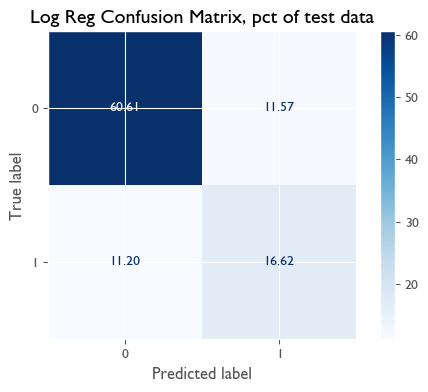

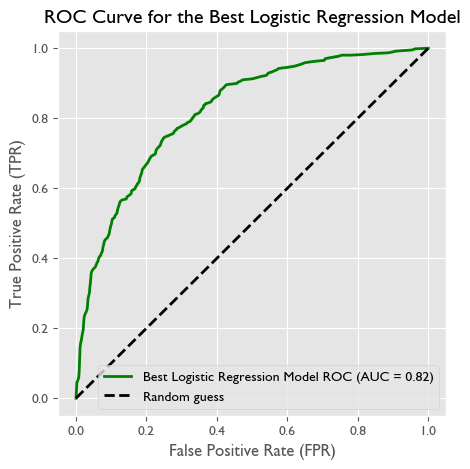

In [51]:
# The best estimator and parameters
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_

# Predict the test set and calculate the accuracy
test_predictions_log = best_model_log.predict(X_test)
test_accuracy_log = accuracy_score(y_test, test_predictions_log)

# Print the best hyperparameters and accuracy
print("Best hyperparameters for Logistic Regression:", best_params_log)
print(f"Test Accuracy for Logistic Regression: {test_accuracy_log:.4f}")

# Print classification report and confusion matrix
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, test_predictions_log))
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, test_predictions_log))

# Display confusion matrix as percentages
cm_log = confusion_matrix(y_test, test_predictions_log) / np.sum(confusion_matrix(y_test, test_predictions_log)) * 100
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Log Reg Confusion Matrix, pct of test data")
plt.show()

# Predict probabilities and compute ROC curve and AUC for the best model
y_scores_best_log = best_model_log.predict_proba(X_test)[:, 1]
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

# Plot the ROC curve for the best model
plt.figure(figsize=(5, 5))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Logistic Regression Model ROC (AUC = {roc_auc_best_log:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve for the Best Logistic Regression Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


Model Interpretation:

*    The optimization of the logistic regression model through grid search has led to better results.
*    The model achieved a test accuracy of approximately 77.23%, showing a solid performance.
*    Examining the classification report reveals a precision of 84% and a recall of 84% for the negative class (0s), with an f1-score of 84%. For the positive class (1s), the precision is 59%, with a recall of 60%, resulting in an f1-score of 59%. These figures indicate a reasonably balanced performance between the two classes.
*    The confusion matrix indicates that the model correctly predicted 660 instances of the negative class and 181 instances of the positive class. The model has 126 false positives and 122 false negatives, highlighting its capability to identify positive intentions accurately, albeit with room for improvement in reducing false negatives.
*    Overall, the results demonstrate an improvement in accuracy and a better balance between precision and recall for both classes.
*    The recall for the minority class (positive intentions) has shown progress, increasing from previous values to 60%.
*    The model's improved ability to differentiate between positive and negative intentions makes it more effective for analysis.

Below, I will import the best parameters into a pipeline for application on a larger Reddit dataset.

In [52]:
# Importing the best parameters from the grid search into the pipeline
best_params_log = grid_search_log.best_params_

# Create a new pipeline with the best parameters
best_pipeline_log = Pipeline([
    ('tfidf_log', TfidfVectorizer(
        max_df=best_params_log['tfidf_log__max_df'],
        tokenizer=best_params_log.get('tfidf_log__tokenizer'),  # Using 'get' for optional parameters
        ngram_range=best_params_log['tfidf_log__ngram_range'])),
    ('logr_log', LogisticRegression(
        C=best_params_log['logr_log__C'], 
        solver=best_params_log['logr_log__solver']))
])

# Fit the best pipeline on the full training set
best_pipeline_log.fit(X_train, y_train)

# Best_pipeline_log predictions calculated
test_predictions_log = best_pipeline_log.predict(X_test)

# Predict probabilities for the test set using the best Logistic Regression model
y_scores_best_log = best_pipeline_log.predict_proba(X_test)[:, 1]

# ROC curve and AUC for the best Logistic Regression model
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

####  Plot showing all logistical model regression ROC curves in one chart

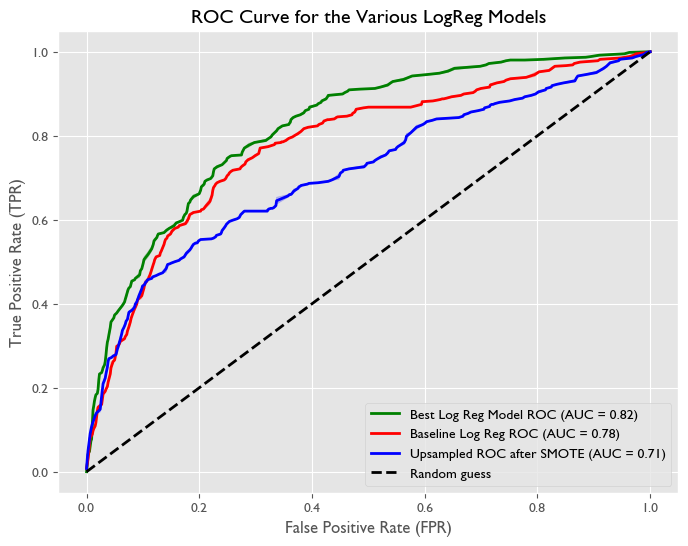

In [53]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Log Reg Model ROC (AUC = {roc_auc_best_log:.2f})') # best model
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'Baseline Log Reg ROC (AUC = {roc_auc:0.2f})') # baseline
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'Upsampled ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')

# Customize the plot
plt.title('ROC Curve for the Various LogReg Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


The ROC AUC also improved from 78% to 82%, so we can confirm the overall improvement in the log reg model performance after the optimisation above. 

In [54]:
# Retraining my final model on the complete labeled dataset (all data available) before pickling it for future use:
# Fit the best pipeline on the full dataset
best_pipeline_log.fit(X, y)

Pipeline(steps=[('tfidf_log',
                 TfidfVectorizer(max_df=0.6, ngram_range=(1, 3),
                                 tokenizer=<function my_tokenizer at 0x2828c61f0>)),
                ('logr_log', LogisticRegression(C=10))])

In [55]:
import joblib

# Specify the file path and name for your pickled object
filename = '../model/03_B_best_pipeline_relevance.pkl'

# Save your model to a file
joblib.dump(best_pipeline_log, filename)

['../model/03_B_best_pipeline_relevance.pkl']

## 3.5. Decision Tree Classifier

### 3.5.1. Set up a pipeline

In [56]:
# Create a pipeline with SVD and a decision tree classifier
pipeline_DT = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    ('svd', TruncatedSVD()),                          # Dimensionality reduction
    ('clf', DecisionTreeClassifier())                 # Classifier
])

In [57]:
# Define the hyperparameters
param_grid_DT = {
    'vect__max_df': [0.7, 0.8],
    'vect__ngram_range': [(1, 2)],
    'vect__tokenizer': [my_tokenizer],
    'svd__n_components': [100, 200],
    'clf__max_depth': [5],
    'clf__min_samples_split': [5],
    'clf__min_samples_leaf': [3]
}

### 3.5.2. Hyperparameter optimization

 I use GridSearchCV to search over a specified parameter grid. 

In [58]:
# Set up GridSearchCV 
grid_search_DT = GridSearchCV(pipeline_DT, param_grid_DT, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

In [59]:
# Run the grid search on DT 
grid_search_DT.fit(X_train, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('svd', TruncatedSVD()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [5], 'clf__min_samples_leaf': [3],
                         'clf__min_samples_split': [5],
                         'svd__n_components': [100, 200],
                         'vect__max_df': [0.7, 0.8],
                         'vect__ngram_range': [(1, 2)],
                         'vect__tokenizer': [<function my_tokenizer at 0x2828c61f0>]},
             scoring='f1_weighted')

In [60]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search_DT.best_params_)

Best hyperparameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'svd__n_components': 100, 'vect__max_df': 0.7, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function my_tokenizer at 0x2828c61f0>}


In [61]:
best_model_DT = grid_search_DT.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds_DT = best_model_DT.predict(X_test)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc_DT = accuracy_score(y_test, test_preds_DT)
print(f"Validation Accuracy with Best Parameters: {val_acc_DT:.4f}")

Validation Accuracy with Best Parameters: 0.7328


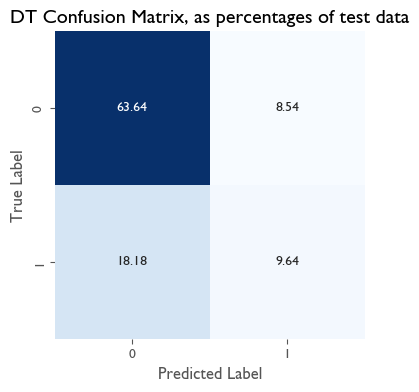

In [62]:
matrix = confusion_matrix(y_test, test_preds_DT)

# Convert confusion matrix to percentages
matrix_percentage = matrix / np.sum(matrix) * 100

plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DT Confusion Matrix, as percentages of test data')
plt.show()

In [63]:
# Printing the classification report
report = classification_report(y_test, test_preds_DT)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       786
           1       0.53      0.35      0.42       303

    accuracy                           0.73      1089
   macro avg       0.65      0.61      0.62      1089
weighted avg       0.71      0.73      0.71      1089



**DT model interpretation**

* The Decision Tree classifier's performance, after hyperparameter tuning and grid search, shows a moderate level of accuracy at 73%, which is lower than the previously constructed logistic regression model's accuracy of 83%.

* The DT model is not able to outperform the baseline accuracy (majority class prediction of 1 with 73% frequency). The model's ability to classify the negative class (0s) is better, with a precision of 78% and a recall of 88%. However, it has a lower performance for the positive class (1s), with a precision of 53% and a recall of 35%. This indicates that while the model is more reliable in predicting the negative class (0s), it frequently misses the positive class (1s), leading to a substantial number of false negatives.

* The f1-score of 83% for the negative class (0s) is significantly higher than the F1 of 42% for the positive class, showing that the model is more conservative in predicting class 1s.

* Comparing the DT classifier to the optimised logreg model built above:
        The Log Reg model has a higher test accuracy (82.89%) compared to the Decision Tree's 73%. This suggests that the Log Reg model is generally more accurate in classifying instances correctly.
        DT has a lower F1 score for the positive class: 0.42 vs 0.72 for logreg.
        For the negative class, while the DT model is effective at identifying negative instances, the Log Reg model is slightly more precise and has a higher recall.
        Overall, on the macro level, the optimised Log Reg model is more balanced in its performance across both classes.

* Overall, the DT model shows an improvement in predicting the negative class but remains less effective overall compared to the optimized Logistic Regression model.

* The optimized Logistic Regression model outperforms the Decision Tree classifier in terms of overall accuracy, precision, recall, and f1-scores across both classes.

## 3.6. Support Vector Machine (SVM) Classifier

This section focuses on implementing a Support Vector Machine model for my dataset.  The code snippets below are adapted from Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 300). O'Reilly Media. Kindle Edition. 

In [64]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4354,)

In [65]:
print(y_test.shape)

(1089,)


In [66]:
# Standard Scaling does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [67]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1089, 1000)

First, let's try to fit a linear SVM model:

In [68]:
# Use StandardScaler with with_mean=False
svm_clf = make_pipeline(StandardScaler(with_mean=False),                        
                        LinearSVC(C=1, random_state=99, dual=False, max_iter=1000000))

# Fit the model
svm_clf.fit(X_matrix_train_dense, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc',
                 LinearSVC(C=1, dual=False, max_iter=1000000,
                           random_state=99))])

In [69]:
cross_val_score(svm_clf, X_matrix_train, y_train).mean()

0.7113102920411206

Next, I am trying a more complex  polynomial model  to see if this helps to mporve accuracy:

In [70]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [71]:
cross_val_score(poly_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7305905485833433

The accuracy score improved a bit, but it is sitll not as high as some other models applied before.  
Let's try to fit a Radial Basis Function kernel: 

In [72]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="rbf", gamma=5, C=0.001))

rbf_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.001, gamma=5))])

In [73]:
cross_val_score(rbf_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7214057035776027

The accuracy is not better with the RBF vector.  The polynomial kernel was a better choice.

Next, I will search for the best SVM model by optimising hyperparameters using gridsearch function:

In [74]:
svm_pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, tokenizer=my_tokenizer),
    SVC()
)

In [75]:
# Define the hyperparameters to search, including those for TF-IDF and SVM
param_grid_svm = {
    'tfidfvectorizer__max_df': [0.7, 0.8],
    'tfidfvectorizer__ngram_range': [(1, 2)],
    'svc__kernel': ['poly'], # also tried 'rbf', 'linear'
    'svc__gamma': [0.1, 1, 10],
    'svc__C': [0.01, 0.1, 1],
    'svc__degree': [3, 4, 6],  # Only relevant for 'poly' kernel
    'svc__coef0': [5, 10, 20]   # Only relevant for 'poly' kernel
}

In [76]:
# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

# Run the grid search on the raw text data
grid_search_svm.fit(X_train, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        tokenizer=<function my_tokenizer at 0x2828c61f0>)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 0.1, 1], 'svc__coef0': [5, 10, 20],
                         'svc__degree': [3, 4, 6], 'svc__gamma': [0.1, 1, 10],
                         'svc__kernel': ['poly'],
                         'tfidfvectorizer__max_df': [0.7, 0.8],
                         'tfidfvectorizer__ngram_range': [(1, 2)]},
             scoring='f1_weighted')

Accuracy: 0.7970615243342516


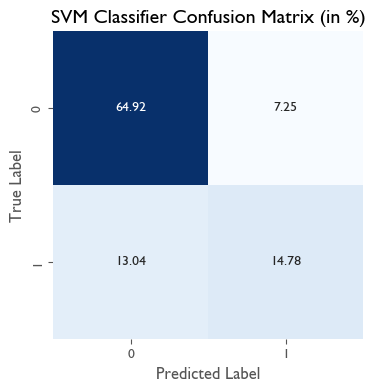

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       786
           1       0.67      0.53      0.59       303

    accuracy                           0.80      1089
   macro avg       0.75      0.72      0.73      1089
weighted avg       0.79      0.80      0.79      1089



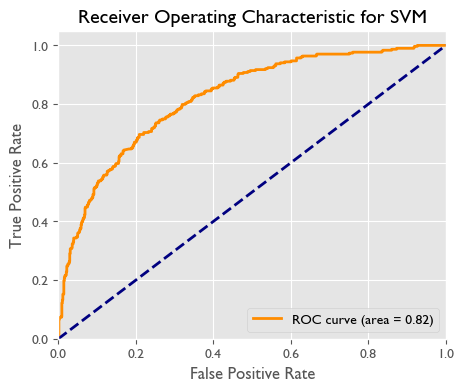

In [77]:
# The Best Model
best_hyperparameters = grid_search_svm.best_params_
best_svm_model = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, 
                    tokenizer=my_tokenizer, 
                    max_df=best_hyperparameters['tfidfvectorizer__max_df'], 
                    ngram_range=best_hyperparameters['tfidfvectorizer__ngram_range']),
                    SVC(kernel=best_hyperparameters['svc__kernel'], 
                        gamma=best_hyperparameters['svc__gamma'], 
                        C=best_hyperparameters['svc__C'], 
                        degree=best_hyperparameters['svc__degree'], 
                        coef0=best_hyperparameters['svc__coef0'], 
                        probability=True)
)
best_svm_model.fit(X_train, y_train)

# Accuracy
test_preds_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, test_preds_svm)
print(f'Accuracy: {accuracy_svm}')

# Confusion Matrix Plot
matrix = confusion_matrix(y_test, test_preds_svm)
matrix_percentage = matrix / np.sum(matrix) * 100
plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix (in %)')
plt.show()

# Classification Report
print(classification_report(y_test, test_preds_svm))

# ROC Plot
y_pred_prob = best_svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()


* The SVM classifier demonstrates a higher overall accuracy of 80%, compared to the Logistic Regression model's accuracy of 77.23%. In terms of precision and recall for the negative class (0s), the SVM outperforms the Logistic 

* Regression, achieving a precision of 83% and recall of 90%, versus 84% precision and 84% recall in the Logistic Regression model. However, for the positive class (1s), the Logistic Regression model shows slightly better balance, with a precision of 59% and recall of 60%, compared to the SVM's precision of 67% and recall of 53%.

* The Logistic Regression model has a slightly higher ROC AUC (0.82), which is identical to the SVM model parameter. 

Given that the reported metrics are somewhat simialr for both models, it suggests that they are equally effective in terms of accuracy, precision, recall, and f1-scores.  

## 3.7. Random Forest Model

In [78]:
random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(X_matrix_train_dense, y_train)

RandomForestClassifier(n_estimators=500)

In [79]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_matrix_train_dense, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_matrix_test_dense, y_test))

In [80]:
# Predictions on test data
y_pred = random_forest_model.predict(X_matrix_test_dense)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print all metrics
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_matrix_train_dense, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_matrix_test_dense, y_test)}
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
Confusion Matrix: 
{conf_matrix}
""")


Performance on fitted data:
Average Decision Tree: 0.882614607257694
Random Forest: 0.994487827285255
----------------
Performance on test data:
Average Decision Tree: 0.6913682277318641
Random Forest: 0.797979797979798
Accuracy: 0.797979797979798
Precision: 0.7873827996343913
Recall: 0.797979797979798
F1 Score: 0.7858316181714721
Confusion Matrix: 
[[721  65]
 [155 148]]



In [81]:
# Printing the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       786
           1       0.69      0.49      0.57       303

    accuracy                           0.80      1089
   macro avg       0.76      0.70      0.72      1089
weighted avg       0.79      0.80      0.79      1089



The random forest model performs quite well on the test set, better than the average of its component trees.

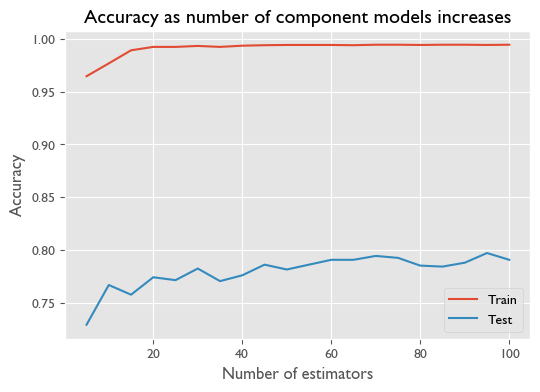

In [82]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

Train set accuracy is improving until approximately 40 components, and stops improviing after that. Test set accuracy seems to be stable with minor variations past 20 components, but seems to be peaking at n=60.  

I will try to experiment with the depth of each tree in the code below:

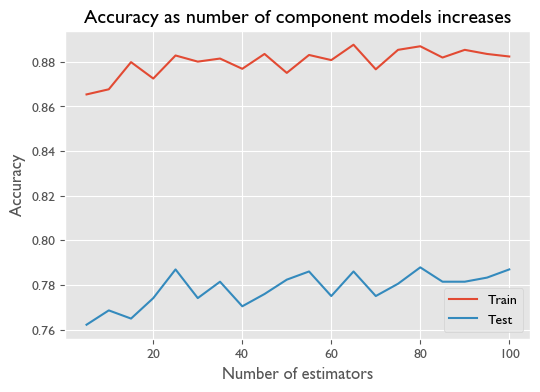

In [83]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n,  max_depth =30)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

In [84]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=my_tokenizer, token_pattern=None)),  
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

In [85]:
# Define the parameter grid
param_grid = {
    'tfidf__tokenizer': [my_tokenizer],
    'svd__n_components': [200,300], 
    'clf__n_estimators': [60, 80, 83, 100],
    'clf__max_depth': [30],
    'clf__max_features': [20, 30, 40]
}

In [86]:
# Create a grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

In [87]:
# Run the grid search on Random Forest 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenizer at 0x2828c61f0>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [30],
                         'clf__max_features': [20, 30, 40],
                         'clf__n_estimators': [60, 80, 83, 100],
                         'svd__n_components': [200, 300],
                         'tfidf__tokenizer': [<function my_tokenizer at 0x2828c61f0>]},
             scoring='f1_weighted')

Best hyperparameters for Random Forest: {'clf__max_depth': 30, 'clf__max_features': 40, 'clf__n_estimators': 83, 'svd__n_components': 200, 'tfidf__tokenizer': <function my_tokenizer at 0x2828c61f0>}


Accuracy: 0.7814508723599632


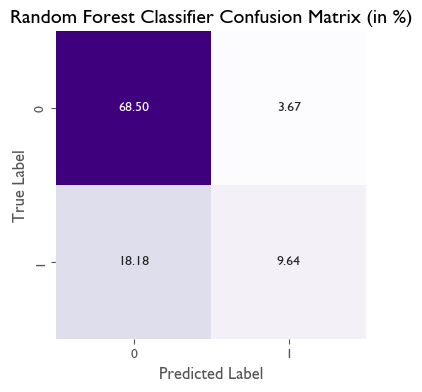

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       786
           1       0.72      0.35      0.47       303

    accuracy                           0.78      1089
   macro avg       0.76      0.65      0.67      1089
weighted avg       0.77      0.78      0.75      1089



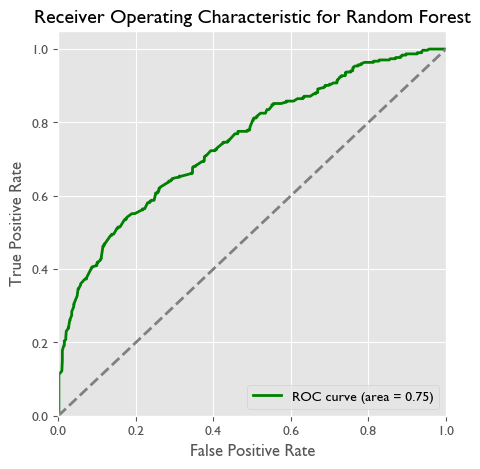

In [88]:
# The best model and parameters
best_hyperparameters_rf = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("Best hyperparameters for Random Forest:", best_hyperparameters_rf)

# Calculating Accuracy
test_preds = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy: {accuracy}')

# Building Confusion Matrix Plot 
matrix = confusion_matrix(y_test, test_preds)
matrix_percentage = matrix / np.sum(matrix) * 100
plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Purples", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Classifier Confusion Matrix (in %)')
plt.show()

# Classification Report
print(classification_report(y_test, test_preds))

# ROC Plot 
if hasattr(best_rf_model, "predict_proba"):
    y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Changed color to green
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Random Forest')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Random Forest model does not support probability predictions.")


Comparing the performance of the Random Forest and Logistic Regression models based on the provided metrics gives me the following insights:

* Logistic Regression shows higher overall accuracy (better by 0.8%).
*    Random Forest: Precision = 79% for class 0 and 72% for class 1, Recall = 95% for class 0 and 35% for class 1. This is quite a bit lower than for the log reg (precision = 84% for class 0 and 59% for class 1, recall = 84% for class 0 and 60% for class 1).
*    Logistic Regression has higher precision and recall for both classes, indicating a better balance between correctly identifying each class.
*    Logistic Regression has higher F1-scores for both classes (0.84 for class 0 and 0.59 for class 1), suggesting better overall performance in balancing precision and recall compared to Random Forest (0.86 for class 0 and 0.47 for class 1).
*    The area under the ROC curve is higher for Logistic Regression by 5%, indicating a better ability to discriminate between the positive and negative classes.
*    Log Reg shows higher macro and weighted average scores, reflecting its superior performance across both classes.

Overall, on all counts the Logreg is a better model than Random Forest.

## 3.8. Conclusion on the Relevant/Irrelevant model

In [89]:
# Listing all the models and their predictions
models = {
    "Logistic Regression": (y_test, test_predictions_log),
    "Decision Tree": (y_test, test_preds_DT),
    "Support Vector Machine": (y_test, test_preds_svm),
    "Random Forest": (y_test, test_preds), 
}

# A list to store model names and their corresponding metrics
model_metrics = []

# Iterating through the models and calculate metrics
for model_name, (true_labels, predicted_labels) in models.items():
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision_scores = precision_score(true_labels, predicted_labels, average=None)
    recall_scores = recall_score(true_labels, predicted_labels, average=None)
    f1_scores = f1_score(true_labels, predicted_labels, average=None)
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)
    macro_f1 = np.mean(f1_scores)

    # Calculate confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Generate classification report
    report = classification_report(true_labels, predicted_labels)

    model_metric = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Class 1 Precision": precision_scores[1],
        "Class 1 Recall": recall_scores[1],
        "Class 0 Precision": precision_scores[0],
        "Class 0 Recall": recall_scores[0],
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1 Score": macro_f1,
        "Confusion Matrix": confusion,
    }

    model_metrics.append(model_metric)

# Create a summary DataFrame
summary_df = pd.DataFrame(model_metrics)

# Display the summary DataFrame
summary_df

,Model,Accuracy,Class 1 Precision,Class 1 Recall,Class 0 Precision,Class 0 Recall,Macro Precision,Macro Recall,Macro F1 Score,Confusion Matrix
0,Logistic Regression,0.77,0.59,0.59,0.84,0.84,0.71,0.72,0.72,"[[659, 127], [123, 180]]"
1,Decision Tree,0.73,0.53,0.35,0.78,0.88,0.65,0.61,0.62,"[[693, 93], [198, 105]]"
2,Support Vector Machine,0.80,0.67,0.53,0.83,0.90,0.75,0.72,0.73,"[[707, 79], [142, 161]]"
3,Random Forest,0.78,0.72,0.35,0.79,0.95,0.76,0.65,0.67,"[[746, 40], [198, 105]]"


The two best models are SVM and the optimised Logreg. they are nerly identical in their performance.  below I plot their ROC curves, they are nearly the same:

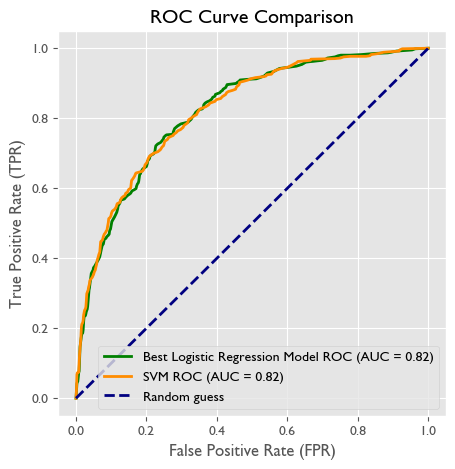

In [90]:
# For the best Logistic Regression model
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

# For the SVM model
y_pred_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plotting both ROC curves
plt.figure(figsize=(5, 5))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Logistic Regression Model ROC (AUC = {roc_auc_best_log:.2f})')
sns.lineplot(x=fpr_svm, y=tpr_svm, color='darkorange', lw=2, label=f'SVM ROC (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


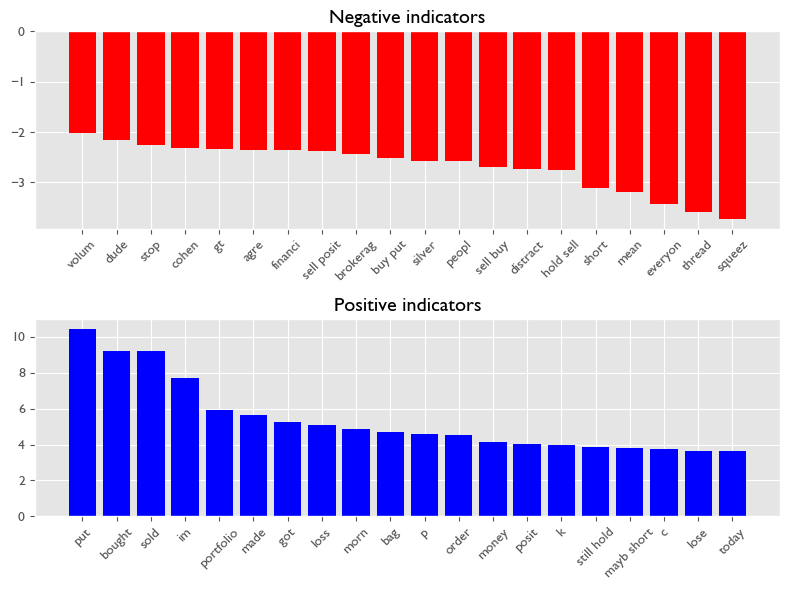

In [91]:
# repeating the plot with the logistic regression coefficients, now for the best optimised log reg model:

def plot_coefs(pipeline):
    # Extract the Logistic Regression model and TfidfVectorizer from the pipeline
    vectorizer = pipeline.named_steps['tfidf_log']
    model = pipeline.named_steps['logr_log']
    
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({
        "coefficient": model.coef_[0], 
        "token": vectorizer.get_feature_names_out()
    })

    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

# Plotting coefficients for the best_pipeline_log model
plot_coefs(best_pipeline_log)


Looking at the coefficients of the final optimised logreg model, and comparing them to the coefficients from the baseline logreg model, I can see that:

* on the positive side, words "put", "bought" and "sold" have gained in significance (their coefficients increased from 2.5 to nearly 10), and many words changed places. We still have a lot of common words in the top 20 list, words such as "made", "got".  
* on the negative (the irrelevant) side, words such as "everyone" increased its weight from -1 to -4, a new word "thread" came into the second position with a significant weight (probably indicating that this message is just a head of a thread, no content). 

Overall, the hyperparameter optimisation have rearranged the weights significantly. 

**SVM and optimised logreg show very similar performance. I will use the LogReg model for processing my Reddit dataset, as it is easier to interpret.**

## 3.9. Testing both models on the labelled dataset

### 3.9.1. Calculating step by step probabilities and labels

In [92]:
# Load the entire RELEVANCE pipeline from the file
pipeline_loaded_yes_no = joblib.load('../model/03_A_best_pipeline_yes_no.pkl')

In [93]:
# Load the entire YES/NO pipeline from the file
pipeline_loaded_relevance = joblib.load('../model/03_B_best_pipeline_relevance.pkl')

In [94]:
df = pd.read_csv('../data/03_labelled_GPT_upsampled_.csv')

In [96]:
# Convert 'Text' column to string
df['Text'] = df['Text'].astype(str)
df['Intent'] = df['Intent'].astype(str)
df.shape

(5443, 3)

In [97]:
# Looking up the pipeline composition 
for step_name, step_process in pipeline_loaded_relevance.named_steps.items():
    print("Step Name:", step_name)
    print("Process/Model:", step_process)
    print()  # Just for a cleaner output

Step Name: tfidf_log
Process/Model: TfidfVectorizer(max_df=0.6, ngram_range=(1, 3),
                tokenizer=<function my_tokenizer at 0x2828c61f0>)

Step Name: logr_log
Process/Model: LogisticRegression(C=10)



In [126]:
# Looking up the pipeline composition 
for step_name, step_process in pipeline_loaded_yes_no.named_steps.items():
    print("Step Name:", step_name)
    print("Process/Model:", step_process)
    print()  

Step Name: tfidf_log
Process/Model: TfidfVectorizer(max_df=0.6, ngram_range=(1, 2),
                tokenizer=<function my_tokenizer at 0x2828c61f0>)

Step Name: logr_log
Process/Model: LogisticRegression(C=100)



The models are nearly identical, they use exactly the same vectorisation process. The only difference is atht the relevance model has a C=10, whereas The buy/sell model has a C=100.  I will not extract the token again, as the Vectorisation steps are the same.  However, I will calculate the new probabilities and new labels using an appropriate model. 

For my analysis, I need to look up specific tokens from each text sentence and look up their coefficients.  In the function extract_tokens below I vectorise the text and save it as a new column, so that I can regrieve the tokens easily, when I need them for interpretation: 

In [98]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.6, ngram_range=(1, 2), tokenizer=my_tokenizer)

# Fit the vectorizer to the entire DataFrame to build the vocabulary
vectorizer.fit(df['Text'])

# Apply the vectorizer to each row and extract tokens
def extract_tokens(row):
    # Transform the text to a sparse matrix
    matrix = vectorizer.transform([row])
    # Get the feature names (tokens)
    tokens = vectorizer.inverse_transform(matrix)
    return tokens[0]

# Apply the function to each row in 'Text' and create a new column 'Tokens'
df['Tokens'] = df['Text'].apply(extract_tokens)

In the code below I generate predictions of the two un-pickled models on my labelled dataset.  I want to see where the models make mistakes and analyse these instances, to undersatdn the model's limitations:

In [99]:
# Assign new X variable 
X_new = df['Text']

# Apply the relevance pipeline to the full labelled dataset
predictions_rel = pipeline_loaded_relevance.predict(X_new)

# Apply the yes/no pipeline to the full labelled dataset
predictions_yes_no = pipeline_loaded_yes_no.predict(X_new)

In [100]:
# Review and process predictions on RELEVANCE

pbb_rel = pipeline_loaded_relevance.predict_proba(X_new)
df['Probab_not_rel']= pbb_rel[:,0] # compute the probabilities of being relevant
df['Probab_yes_rel']= pbb_rel[:,1] # compute the probabilities of being irrelevant
df['Post Relevance'] = predictions_rel

In [101]:
# Review and process predictions on YES/NO

pbb_yes_no = pipeline_loaded_yes_no.predict_proba(X_new)
df['Probab_buy']= pbb_yes_no[:,0]  # compute the probabilities of being yes
df['Probab_sell']= pbb_yes_no[:,1] # compute the probabilities of being no
df['Post Buy/Sell'] = predictions_yes_no

### 3.9.2. Analysing the relevant/Irrelevant model mistakes

Now that the predictions and probabilities have been generated, I want to build a crosstab to see the misclassifications distribution:

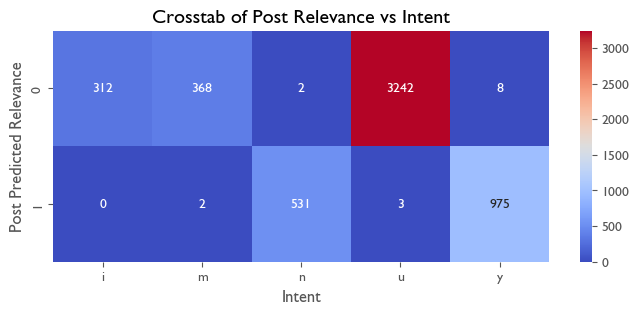

In [102]:
# Crosstab for  distribution of new labels - for BUY and SELL classification
crosstab = pd.crosstab(df['Post Relevance'], df['Intent'])

# A heatmap of the crosstab
plt.figure(figsize=(8, 3)) 
sns.heatmap(crosstab, annot=True, fmt="d", cmap="coolwarm")
plt.title('Crosstab of Post Relevance vs Intent')
plt.xlabel('Intent')
plt.ylabel('Post Predicted Relevance')
plt.show()

Observation: 
* The model correctly classifies most of the rows, with just a few exceptions. I want to see what kind of messages got misclassified and why. IN the code below I select those messages that got misclassified and look into their texts, and compare to the coefficients to understand the rating ratonale.  I filter the misclasified rows into a new dataframe and examine them. 

To achieve that I go through the following steps:
1) Look up a specific row in my filtered dataframe with misclassified rows, using index number.
2) Retrieve the list of tokens from that row from the 'Tokens' column.
3) Map these tokens to the coefficients of the logistic regression model within the loaded pipeline_loaded_relevance.

In [103]:
# Function to look up a row and map tokens to coefficients
def map_tokens_to_coefficients(df, index, pipeline):
    # Step 1: Look up the specific row
    row = df.loc[index]

    # Step 2: Retrieve the list of tokens from the 'Tokens' column
    tokens = row['Tokens']

    # Extract the TfidfVectorizer and Logistic Regression model from the pipeline
    vectorizer = pipeline.named_steps['tfidf_log']
    model = pipeline.named_steps['logr_log']

    # Get the feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]

    # Map tokens to coefficients
    token_coeff_map = {}
    for token in tokens:
        if token in feature_names:
            token_index = list(feature_names).index(token)
            token_coeff_map[token] = coefficients[token_index]

    return token_coeff_map

I will look at false negatives first: 

In [119]:
# Filter the DataFrame for misclassified relevance
filtered_rel = df.loc[((df['Post Relevance'] == 0) & (df['Intent'] == 'n')) |
                      ((df['Post Relevance'] == 0) & (df['Intent'] == 'y'))]
pd.set_option('display.max_colwidth', None)
filtered_rel

,id,Text,Intent,Tokens,Probab_not_rel,Probab_yes_rel,Post Relevance,Probab_buy,Probab_sell,Post Buy/Sell
362,t3_kxsd2p,Buying GME now,y,[buy],0.81,0.19,0,0.00,1.00,1
417,t3_l9yphs,AMC GME checking in 🦧🦍🦧🦍🦧🦍🦧🦍,y,[check],0.55,0.45,0,0.01,0.99,1
785,t3_lpl1je,GME 45 EOD,y,[eod],0.74,0.26,0,0.02,0.98,1
1126,t3_kyvkcz,"34% in BB, 33% in GME and 33% in PLTR. 🤷‍♂️",y,[],0.90,0.10,0,0.17,0.83,1
2275,t3_l68yl9,I’m holding both GME and NOK.. why can’t we have both??,y,[hold],0.71,0.29,0,0.00,1.00,1
3866,t3_laor4s,Buying more $GME🚀🚀🚀,y,[buy],0.81,0.19,0,0.00,1.00,1
4489,t3_l9wner,Buying GME and holding.,y,"[hold, buy hold, buy]",0.77,0.23,0,0.00,1.00,1
4599,t3_l80upw,1017 GME and HOLDING!!,y,[hold],0.71,0.29,0,0.00,1.00,1
5430,r81wvs,"GME: Down 6.43%,",n,[],0.90,0.10,0,0.17,0.83,1
5440,ncf668,"Maybe they shorted GME,",n,"[short, mayb short, mayb]",0.51,0.49,0,0.96,0.04,0


The model misclassified mostly positive messages, treating them as irrelevant.  The misclassified messages are all quite short, with a punchy recomemndation to hold or to buy securities: "Buying more $GME🚀🚀🚀", "Buying GME and holding".  The coefficians of each word can explain why it was treated in a certain way:

In [125]:
# Looking up specific sentenses
index = 4990
token_coeff_map = map_tokens_to_coefficients(df, index, pipeline_loaded_relevance)

# Print the mapping
for token, coeff in token_coeff_map.items():
    print(f"Token: {token}, Coefficient: {coeff}")

Token: p, Coefficient: 4.570720639348939


Observation:

* The word "buy" has a positive coefficient, so theoretically it should be treated as a relevant message.  However, probbaly the sentence was too short to be treated as important enough, and the use of just one word "buy" once was not sufficient for the model to classify it as "relevant". 
* As to the misclassified negative messages, I actually think the model did a pretty good job classifying them as irrelevant, as in my personal humble opinion, these messages  (index 5430 and 5440 above) are not expressing any intent to buy stocks, so I am surprised they were labelled as "n" by the researchers. 
* **Overall, I will keep it in mind that the model tends to penalise short positive messages, even if they express a clear buy recomemndation. This is a shortcoming of this model.**  

Now I will look at other misclassifications, the false positives:

In [121]:
# Filter the DataFrame for misclassified relevance
filtered_rel = df.loc[((df['Post Relevance'] == 1) & (df['Intent'] == 'u')) |
                      ((df['Post Relevance'] == 1) & (df['Intent'] == 'm')) |
                      ((df['Post Relevance'] == 1) & (df['Intent'] == 'i'))]
pd.set_option('display.max_colwidth', None)
filtered_rel

,id,Text,Intent,Tokens,Probab_not_rel,Probab_yes_rel,Post Relevance,Probab_buy,Probab_sell,Post Buy/Sell
1042,t3_msigqh,He bought GME,u,[bought],0.00,1.00,1,0.00,1.00,1
2131,t3_msb6mb,why don't you buy puts on gme then?,u,"[put, buy put, buy]",0.23,0.77,1,1.00,0.00,0
2163,t3_l7iorh,Sell BB and all in GME?,m,[sell],0.38,0.62,1,0.97,0.03,0
2554,t3_kdue98,GME puts ?,u,[put],0.00,1.00,1,1.00,0.00,0
3451,t3_l68k3q,GME 1K,m,[k],0.15,0.85,1,0.03,0.97,1


There are 3 posts rated "u" and 2 posts rated "m" by the researchers that were classified as "relevant".  Looking at the words that constitute these posts, I can see that this happened because of the presence of the following tokens:

- Token: k, Coefficient: 3.9470566256884907
- Token: put, Coefficient: 10.448570439972526
- Token: sell, Coefficient: 2.731066023573698
- Token: buy put, Coefficient: -2.5155818623503454
- Token: buy, Coefficient: 0.7752912057587599
- Token: bought, Coefficient: 9.180955412592294

For example, in the message index 2554 "GME puts ?" we see a word "put" which is the word that has one of the highest coefficients for a signal that the stock is relevant. That's why the model classified it as relevant. The model does not recognise the context and sequence of words, it also ignores punctuation, therefore a question was classified as a negative sell signal.  

**This is a clear limitation of the BOW approach.**

### 3.9.3. Analysing the BUY/SELL model mistakes

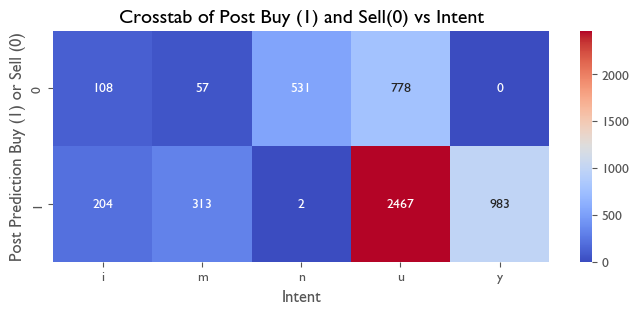

In [122]:
# Crosstab for  distribution of new labels - for BUY and SELL classification
crosstab = pd.crosstab(df['Post Buy/Sell'], df['Intent'])

# A heatmap of the crosstab
plt.figure(figsize=(8, 3)) 
sns.heatmap(crosstab, annot=True, fmt="d", cmap="coolwarm")
plt.title('Crosstab of Post Buy (1) and Sell(0) vs Intent')
plt.xlabel('Intent')
plt.ylabel('Post Prediction Buy (1) or Sell (0)')
plt.show()

In [123]:
# Filter the DataFrame for misclassified negatives
filtered_yes_no = df.loc[((df['Post Buy/Sell'] == 1) & (df['Intent'] == 'n')) |
                      ((df['Post Buy/Sell'] == 0) & (df['Intent'] == 'y'))]
pd.set_option('display.max_colwidth', None)
filtered_yes_no

,id,Text,Intent,Tokens,Probab_not_rel,Probab_yes_rel,Post Relevance,Probab_buy,Probab_sell,Post Buy/Sell
4990,t3_k4ixya,GME 12/4 $14.5p,n,[p],0.09,0.91,1,0.35,0.65,1
5430,r81wvs,"GME: Down 6.43%,",n,[],0.90,0.10,0,0.17,0.83,1


Observations: 

* The classification crosstab shows pretty good performance on this labelled dataset with just a few misclassifications. This model is more accurate than the previous one.  
* The tokenisation process for the row index 5430 did not generate any tokens.  The message is short, and both words are on the stop list. The numbers were stripped out during the tokenisation phase, too. 
* The short message index 4990 just includes a description of a put option. The researchers labelled it as "n", although in my interpretation this is an informative message, not a call for action. As the token "p" (for "put option")  

### 3.9.4. Conclusions on the model mistakes analysis

* The overall model performance is quite satisfactory; however, I identified several areas where the model miscalculates the label:

1) Short buy messages (for example, "Buy GME!") tend to be classified as "irrelevant".  There is not enough positive words in the model to classify such messages as "relevant". 
2) Short questions, which don’t express a view but ask for an opinion, are treated as statements, since the punctuation is stripped away during the pre-cleaning steps and the BOW approach ignores the sentence structure and context. 

I need to be aware of these limitations whenj applying my models in real life. 